# Exploring RXTE spectral observations of Eta Car

## Learning Goals

By the end of this tutorial, you will:

- Know how to find and use observation tables hosted by HEASARC.
- Be able to search for RXTE observations of a named source.
- Understand how to access RXTE spectra stored in the HEASARC S3 bucket.
- Be capable of downloading and visualizing retrieved spectra.
- Perform basic spectral fits and explore how spectral properties change with time.
- Use simple machine learning techniques to perform a model-independent analysis of the spectral data.


## Introduction
This notebook demonstrates an analysis of archival Rossi X-ray Timing Explorer (RXTE) Proportional Counter Array (PCA) data, particularly spectra of Eta Car.

The RXTE archive contains standard data products that can be used without re-processing the data, which are summarized in this [description of standard RXTE data products](https://heasarc.gsfc.nasa.gov/docs/xte/recipes/stdprod_guide.html).

We find all the standard spectra and then load, visualize, and fit them with PyXspec.

### Inputs

- The name of the source we are going to explore using archival RXTE observations - **Eta Car**.

### Outputs

- Downloaded source and background spectra.
- Downloaded spectral response files.
- Visualization of all spectra and fitted spectral models.
- A figure showing powerlaw model parameter distributions from all spectral fits.
- A figure showing how fitted model parameters vary with time.

### Runtime

As of 16th January 2026, this notebook takes ~3 minutes to run to completion on Fornax, using the 'small' server with 8GB RAM/ 2 cores.

## Imports & Environments
We need the following Python modules:

In [1]:
import contextlib
import os

import astropy.io.fits as fits
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import xspec as xs
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.units import Quantity
from astroquery.heasarc import Heasarc
from cycler import cycler
from matplotlib.ticker import FuncFormatter
from s3fs import S3FileSystem
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from umap import UMAP

/opt/envs/heasoft/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Global Setup

### Functions

### Constants

In [2]:
SRC_NAME = "Eta Car"

### Configuration

The only configuration we do is to set up the root directory where we will store downloaded data.

In [3]:
# -------------- Set paths and create directories --------------
if os.path.exists("../../../_data"):
    ROOT_DATA_DIR = "../../../_data/RXTE/"
else:
    ROOT_DATA_DIR = "RXTE/"

ROOT_DATA_DIR = os.path.abspath(ROOT_DATA_DIR)

# Make sure the download directory exists.
os.makedirs(ROOT_DATA_DIR, exist_ok=True)
# --------------------------------------------------------------

***

## 1. Finding the data

To identify the relevant RXTE data, we could use [Xamin](https://heasarc.gsfc.nasa.gov/xamin/), the HEASARC web portal, the Virtual Observatory (VO) python client `pyvo`, or **the Astroquery module** (our choice for this demonstration).

### Using Astroquery to find the HEASARC table that lists all of RXTE's observations

Using the `Heasarc` object from Astroquery, we can easily search through all of HEASARC's catalog holdings. In this
case we need to find what we refer to as a 'master' catalog/table, which summarizes all RXTE observations present in
our archive. We can do this by passing the `master=True` keyword argument to the `list_catalogs` method.

In [4]:
table_name = Heasarc.list_catalogs(keywords="xte", master=True)[0]["name"]
table_name

np.str_('xtemaster')

### Identifying RXTE observations of Eta Car

Now that we have identified the HEASARC table that contains summary information about all of RXTE's observations, we're going to search
it for observations of **Eta Car**.

For convenience, we pull the coordinate of Eta Car from the [Strasbourg astronomical Data Center (CDS)](https://cds.unistra.fr/) name resolver functionality built into Astropy's
`SkyCoord` class.

```{caution}
You should always carefully vet the positions you use in your own work!
```

In [5]:
# Get the coordinate for Eta Car
pos = SkyCoord.from_name("Eta Car")
pos

<SkyCoord (ICRS): (ra, dec) in deg
    (161.2647742, -59.6844309)>

Then we can use the `query_region` method of `Heasarc` to search for observations with a central coordinate that
falls within a radius of $0.2^{\prime}$ of Eta Car.

```{hint}
Each HEASARC catalog has its own default search radius, but we select $0.2^{\prime}$ to limit the number of results.
You should carefully consider the search radius you use for your own science case!
```

In [6]:
valid_obs = Heasarc.query_region(
    pos, catalog=table_name, radius=Quantity(0.2, "arcmin")
)
valid_obs

obsid,prnb,status,pi_lname,pi_fname,target_name,ra,dec,time,duration,exposure,__row
,,,,,,deg,deg,d,s,s,
object,int32,object,object,object,object,float64,float64,float64,float64,float64,object
94002-01-15-00,94002,archived,TOO,PUBLIC,ETA_CAR,161.2650,-59.6845,55000.4322,2518,1197,16751
93002-01-17-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54398.83492,2179,924,16752
93002-02-52-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54808.7048,1582,905,16753
93002-02-53-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54810.66671,1510,829,16754
93002-02-54-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54812.85572,1430,927,16755
93002-01-47-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54606.98389,3246,863,16756
93002-02-55-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54814.29519,2168,771,16757
93002-02-56-00,93002,archived,CORCORAN,MICHAEL,ETA_CAR,161.2650,-59.6845,54816.35667,2442,885,16758


Alternatively, if you wished to place extra constraints on the search, you could use the more complex `query_tap` method
to pass a full Astronomical Data Query Language (ADQL) query. Using ADQL allows you to be much more flexible but in
many cases may not be necessary.

This demonstration runs the same spatial query as before but also includes a stringent exposure time requirement; you might do this to try and only
select the highest signal-to-noise observations.

Note that we call the `to_table` method on the result of the query to convert the result into an Astropy table, which
is the form required to pass to the `locate_data` method (see the next section).

In [7]:
query = (
    "SELECT * "
    "from {c} as cat "
    "where contains(point('ICRS',cat.ra,cat.dec), circle('ICRS',{ra},{dec},0.0033))=1 "
    "and cat.exposure > 1200".format(ra=pos.ra.value, dec=pos.dec.value, c=table_name)
)

alt_obs = Heasarc.query_tap(query).to_table()
alt_obs

__row,pi_lname,pi_fname,pi_no,prnb,cycle,subject_category,target_name,time_awarded,ra,dec,priority,tar_no,obsid,time,duration,exposure,status,scheduled_date,observed_date,processed_date,archived_date,hexte_anglea,hexte_angleb,hexte_dwella,hexte_dwellb,hexte_energya,hexte_energyb,hexte_modea,hexte_modeb,pca_config1,pca_config2,pca_config3,pca_config4,pca_config5,pca_config6,lii,bii,__x_ra_dec,__y_ra_dec,__z_ra_dec
,,,,,,,,s,deg,deg,,,,d,s,s,,d,d,d,d,,,,,,,,,,,,,,,deg,deg,,,
object,object,object,int32,int32,int16,object,object,float64,float64,float64,int16,int16,object,float64,float64,float64,object,float64,float64,int32,int32,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64
16769,CORCORAN,MICHAEL,196,93002,12,STARS,ETA_CAR,85000.0,161.2650,-59.6845,1,2,93002-02-66-00,54836.05479,2428,1267,archived,54836.05479,54836.05479,54845,55211,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8US_256_DX1F,E_8US_256_DX1F,STANDARD1,STANDARD2,GOODXENON1_2S,GOODXENON2_2S,IDLE,IDLE,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16771,CORCORAN,MICHAEL,196,93002,12,STARS,ETA_CAR,85000.0,161.2650,-59.6845,1,2,93002-02-68-00,54840.44851,2842,1335,archived,54840.44851,54840.44851,54850,55218,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8US_256_DX1F,E_8US_256_DX1F,STANDARD1,STANDARD2,GOODXENON1_2S,GOODXENON2_2S,IDLE,IDLE,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16777,CORCORAN,MICHAEL,196,93002,12,STARS,ETA_CAR,85000.0,161.2650,-59.6845,1,2,93002-02-73-00,54850.24669,3308,1651,archived,54850.24669,54850.24669,54859,55225,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8US_256_DX1F,E_8US_256_DX1F,STANDARD1,STANDARD2,GOODXENON1_2S,GOODXENON2_2S,IDLE,IDLE,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16789,CORCORAN,MICHAEL,196,93002,12,STARS,ETA_CAR,85000.0,161.2650,-59.6845,1,2,93002-02-84-00,54872.22313,2542,1283,archived,54872.22313,54872.22313,54880,55247,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8US_256_DX1F,E_8US_256_DX1F,STANDARD1,STANDARD2,GOODXENON1_2S,GOODXENON2_2S,IDLE,IDLE,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16797,TOO,PUBLIC,0,94002,13,STARS,ETA_CAR,1310.0,161.2650,-59.6845,0,1,94002-01-05-00,54930.46883,1725,1313,archived,54930.46883,54930.46883,54938,--,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8us_256_DX1F,E_8us_256_DX1F,GOODXENON1_2S,GOODXENON2_2S,GOODVLE1_2S,STANDARD1B,STANDARD2F,GOODVLE2_2S,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16799,TOO,PUBLIC,0,94002,13,STARS,ETA_CAR,1210.0,161.2650,-59.6845,0,1,94002-01-07-00,54944.20307,2695,1207,archived,54944.20307,54944.20307,54952,--,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8us_256_DX1F,E_8us_256_DX1F,GOODXENON1_2S,GOODXENON2_2S,GOODVLE1_2S,STANDARD1B,STANDARD2F,GOODVLE2_2S,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16803,CORCORAN,MICHAEL,196,93002,12,STARS,ETA_CAR,65000.0,161.2650,-59.6845,1,1,93002-01-49-00,54620.98435,2615,1504,archived,54620.98435,54620.98435,54629,54994,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8US_256_DX1F,E_8US_256_DX1F,STANDARD1,STANDARD2,GOODXENON1_2S,GOODXENON2_2S,IDLE,IDLE,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778
16804,TOO,PUBLIC,0,94002,13,STARS,ETA_CAR,1400.0,161.2650,-59.6845,0,1,94002-01-11-00,54971.98391,2823,1401,archived,54971.98391,54971.98391,54980,--,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,DEFAULT,E_8us_256_DX1F,E_8us_256_DX1F,GOODXENON1_2S,GOODXENON2_2S,GOODVLE1_2S,STANDARD1B,STANDARD2F,GOODVLE2_2S,287.5969,-0.6295,0.162125023877781,-0.478016026673964,-0.863259031157778


### Using Astroquery to fetch datalinks to RXTE datasets

We've already figured out which HEASARC table to pull RXTE observation information from, and then used that table
to identify specific observations that might be relevant to our target source (Eta Car). Our next step is to pinpoint
the exact location of files from each observation that we can use to visualize the spectral emission of our source.

Just as in the last two steps, we're going to make use of Astroquery. The difference is, rather than dealing with tables of
observations, we now need to construct 'datalinks' to places where specific files for each observation are stored. In
this demonstration we're going to pull data from the HEASARC 'S3 bucket', an Amazon-hosted open-source dataset
containing all of HEASARC's data holdings.

In [8]:
data_links = Heasarc.locate_data(valid_obs, "xtemaster")
data_links

ID,access_url,sciserver,aws,content_length,error_message
,,,,byte,
object,object,str50,str63,int64,object
ivo://nasa.heasarc/xtemaster?16751,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO13/P94002/94002-01-15-00//,/FTP/xte/data/archive/AO13/P94002/94002-01-15-00/,s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00/,--,
ivo://nasa.heasarc/xtemaster?16751,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO13/P94002/94002-01-15-00A//,/FTP/xte/data/archive/AO13/P94002/94002-01-15-00A/,s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00A/,--,
ivo://nasa.heasarc/xtemaster?16751,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO13/P94002/94002-01-15-00Z//,/FTP/xte/data/archive/AO13/P94002/94002-01-15-00Z/,s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00Z/,--,
ivo://nasa.heasarc/xtemaster?16751,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO13/P94002//94002-01-15-00/,/FTP/xte/data/archive/AO13/P94002/94002-01-15-00/,s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00/,--,
ivo://nasa.heasarc/xtemaster?16751,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO13/P94002//94002-01/,/FTP/xte/data/archive/AO13/P94002/94002-01/,s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01/,--,
ivo://nasa.heasarc/xtemaster?16752,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO12/P93002/93002-01-17-00//,/FTP/xte/data/archive/AO12/P93002/93002-01-17-00/,s3://nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-17-00/,--,
ivo://nasa.heasarc/xtemaster?16752,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO12/P93002/93002-01-17-00A//,/FTP/xte/data/archive/AO12/P93002/93002-01-17-00A/,s3://nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-17-00A/,--,
ivo://nasa.heasarc/xtemaster?16752,https://heasarc.gsfc.nasa.gov/FTP/xte/data/archive/AO12/P93002/93002-01-17-00Z//,/FTP/xte/data/archive/AO12/P93002/93002-01-17-00Z/,s3://nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-17-00Z/,--,


## 2. Acquiring the data
We now know where the relevant RXTE-PCA spectra are stored in the HEASARC S3 bucket and will proceed to download
them for local use.

```{caution}
***Many workflows are being adapted to stream remote data directly into memory*** (RAM), rather than
downloading it onto disk storage, *then* reading into memory - PyXspec does not yet support this way of
operating, but our demonstrations will be updated when it does.
```


### The easiest way to download data

At this point, you may wish to simply download the entire set of files for all the observations you've identified.
That is easily achieved using Astroquery, with the `download_data` method of `Heasarc`, we just need to pass
the datalinks we found in the previous step.

We demonstrate this approach using the first three entries in the datalinks table, but in the following sections will
demonstrate a more complicated, but targeted, approach that will let us download only the RXTE-PCA spectra and their
supporting files:

In [9]:
Heasarc.download_data(data_links[:3], host="aws", location=ROOT_DATA_DIR)

INFO: Downloading data AWS S3 ... [astroquery.heasarc.core]
INFO: Enabling anonymous cloud data access ... [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00A/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00Z/ [astroquery.heasarc.core]


INFO: downloading s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00A/ [astroquery.heasarc.core]


INFO: downloading s3://nasa-heasarc/xte/data/archive/AO13/P94002/94002-01-15-00Z/ [astroquery.heasarc.core]


### Downloading only RXTE-PCA spectra

Rather than downloading all files for all our observations, we will now _only_ fetch those that are directly
relevant to what we want to do in this notebook. This method is a little more involved than using Astroquery, but
it is more efficient and flexible.

We make use of a Python module called `s3fs`, which allows us to interact with files stored on Amazon's S3
platform through Python commands.

We create an `S3FileSystem` object, which lets us interact with the S3 bucket as if it were a filesystem.

```{hint}
Note the `anon=True` argument, as attempting access to the HEASARC S3 bucket will fail without it!
```

In [10]:
s3 = S3FileSystem(anon=True)

Now we identify the specific files we want to download. The datalink table tells us the AWS S3 'path' (the Uniform
Resource Identifier, or URI) to each observation's data directory, the [RXTE documentation](https://heasarc.gsfc.nasa.gov/docs/xte/start_guide.html#directories)
tells us that the automatically generated data products are stored in a subdirectory called 'stdprod', and the
[RXTE Guest Observer Facility (GOF) standard product guide](https://heasarc.gsfc.nasa.gov/docs/xte/recipes/stdprod_guide.html)
shows us that PCA spectra and supporting files are named as:

- **xp{ObsID}_s2.pha** - the spectrum automatically generated for the target of the RXTE observation.
- **xp{ObsID}_b2.pha** - the background spectrum companion to the source spectrum.
- **xp{ObsID}.rsp** - the supporting file that defines the response curve (sensitivity over energy range) and redistribution matrix (a mapping of channel to energy) for the RXTE-PCA instrument during the observation.

We set up patterns for these three files for each datalink entry, and then use the `expand_path` method of
our previously set-up S3 filesystem object to find all the files that match the pattern. This is useful because the
RXTE datalinks we found might include sections of a particular observation that do not have standard products
generated, for instance, the slewing periods before/after the telescope was aligned on target.

In [11]:
all_file_patt = [
    os.path.join(base_uri, "stdprod", fp)
    for base_uri in data_links["aws"].value
    for fp in ["xp*_s2.pha*", "xp*_b2.pha*", "xp*.rsp*"]
]

val_file_uris = s3.expand_path(all_file_patt)
val_file_uris[:10]

['nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-01-00/stdprod/xp93002010100.rsp.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-01-00/stdprod/xp93002010100_b2.pha.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-01-00/stdprod/xp93002010100_s2.pha.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-02-00/stdprod/xp93002010200.rsp.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-02-00/stdprod/xp93002010200_b2.pha.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-02-00/stdprod/xp93002010200_s2.pha.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-03-00/stdprod/xp93002010300.rsp.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-03-00/stdprod/xp93002010300_b2.pha.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-03-00/stdprod/xp93002010300_s2.pha.gz',
 'nasa-heasarc/xte/data/archive/AO12/P93002/93002-01-04-00/stdprod/xp93002010400.rsp.gz']

Now we can just use the `get` method of our S3 filesystem object to download all the valid spectral files!

In [12]:
spec_file_path = os.path.join(ROOT_DATA_DIR, "rxte_pca_demo_spec")
ret = s3.get(val_file_uris, spec_file_path)

## 3. Reading the data into PyXspec

We have acquired the spectra and their supporting files and will perform very basic visualizations and model fitting
using the Python wrapper to the ubiquitous X-ray spectral fitting code, XSPEC. To learn more advanced uses of
PyXspec, please refer to the [documentation](https://heasarc.gsfc.nasa.gov/docs/software/xspec/python/html/index.html)
or examine other tutorials in this repository.

We set the ```chatter``` parameter to 0 to reduce the printed text given the large number of files we are reading.

### Configuring PyXspec

In [13]:
xs.Xset.chatter = 0

# Other xspec settings
xs.Plot.area = True
xs.Plot.xAxis = "keV"
xs.Plot.background = True
xs.Fit.statMethod = "cstat"
xs.Fit.query = "no"
xs.Fit.nIterations = 500

# Store the current working directory
cwd = os.getcwd()

### Reading and fitting the spectra

This code will read in the spectra and fit a simple power-law model with default start values (we do not necessarily
recommend this model for this type of source, nor leaving parameters set to default values). It also extracts the
spectrum data points, fitted model data points for plotting, and the fitted model parameters.

Note that we move into the directory where the spectra are stored. This is because the main source spectra files
have relative paths to the background and response files in their headers, and if we didn't move into the
working directory, then PyXspec would not be able to find them.

The directory change is performed using a _context manager_, so that if anything goes wrong during the loading
process, we will still automatically return to the original working directory.

In [14]:
# The spectra will be saved in a list
spec_plot_data = []
fit_plot_data = []
pho_inds = []
norms = []

# Picking out just the source spectrum files
src_sp_files = [rel_uri.split("/")[-1] for rel_uri in val_file_uris if "_s2" in rel_uri]

# We use a context manager to temporarily change the working directory to where
#  the spectra are stored
with contextlib.chdir(spec_file_path):

    # Iterating through all the source spectra
    with tqdm(
        desc="Loading/fitting RXTE spectra", total=len(src_sp_files), disable=True
    ) as onwards:
        for sp_name in src_sp_files:
            # Clear out the previously loaded dataset and model
            xs.AllData.clear()
            xs.AllModels.clear()

            # Loading in the spectrum
            spec = xs.Spectrum(sp_name)

            # Set up a powerlaw and then fit to the current spectrum
            model = xs.Model("powerlaw")
            xs.Fit.perform()

            # Extract the parameter values
            pho_inds.append(model.powerlaw.PhoIndex.values[:2])
            norms.append(model.powerlaw.norm.values[:2])

            # Create an XSPEC plot (not visualized here) and then extract the
            #  information required to let us plot it using matplotlib
            xs.Plot("data")
            spec_plot_data.append(
                [xs.Plot.x(), xs.Plot.xErr(), xs.Plot.y(), xs.Plot.yErr()]
            )
            fit_plot_data.append(xs.Plot.model())

            onwards.update(1)

pho_inds = np.array(pho_inds)
norms = np.array(norms)

### Visualizing the spectra

Using the data extracted in the last step, we can plot the spectra and fitted models using matplotlib.

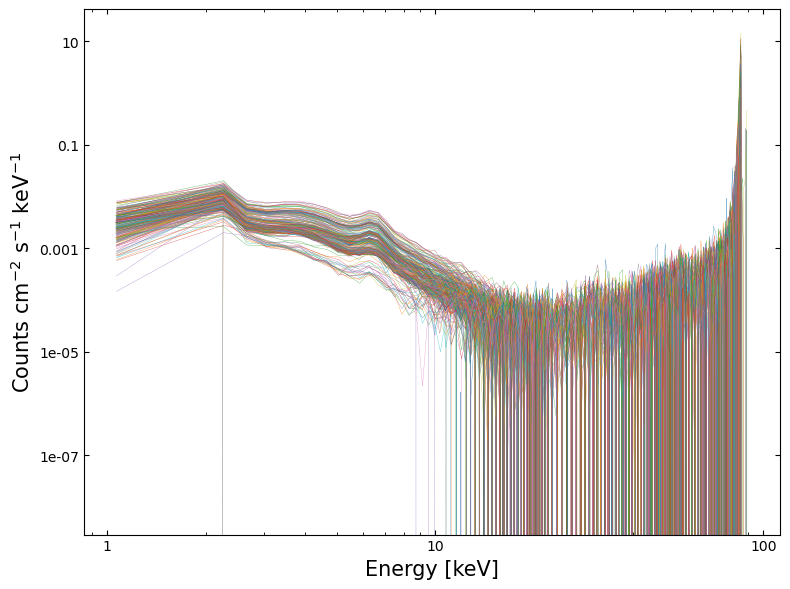

In [15]:
# Now we plot the spectra
fig = plt.figure(figsize=(8, 6))

plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

for x, xerr, y, yerr in spec_plot_data:
    plt.plot(x, y, linewidth=0.2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Energy [keV]", fontsize=15)
plt.ylabel(r"Counts cm$^{-2}$ s$^{-1}$ keV$^{-1}$", fontsize=15)

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

plt.tight_layout()
plt.show()

### Visualizing the fitted models

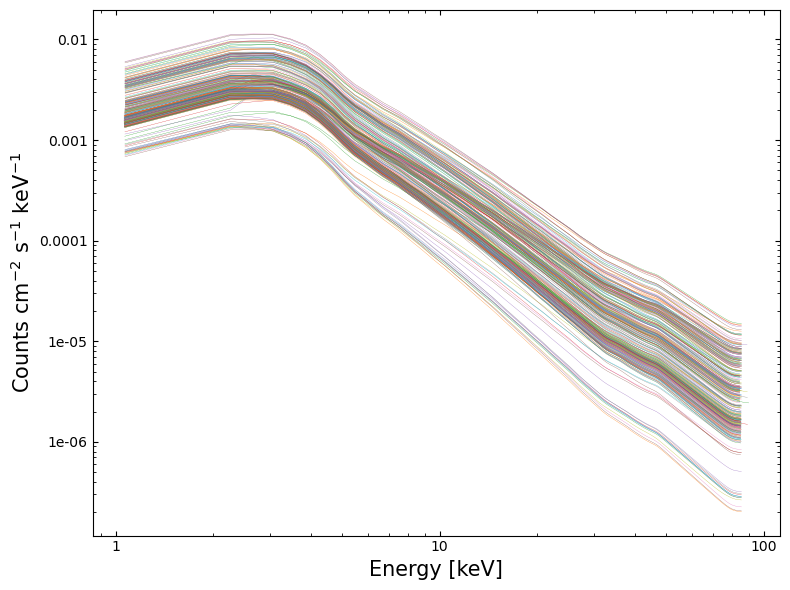

In [16]:
fig = plt.figure(figsize=(8, 6))

plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

for fit_ind, fit in enumerate(fit_plot_data):
    plt.plot(spec_plot_data[fit_ind][0], fit, linewidth=0.2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Energy [keV]", fontsize=15)
plt.ylabel(r"Counts cm$^{-2}$ s$^{-1}$ keV$^{-1}$", fontsize=15)

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

plt.tight_layout()
plt.show()

## 4. Exploring model fit results

As we have fit models to all these spectra and retrieved the parameter's values, we should take a look at them!

Exactly what you do at this point will depend entirely upon your science case and the type of object you've been
analyzing. However, any analysis will benefit from an initial examination of the fitted parameter values (particularly if
you have fit hundreds of spectra, as we have).

### Fitted model parameter distributions

This shows us what the distributions of the 'Photon Index' (related to the power-law slope) and the
model normalization look like. We can see that the distributions are not particularly symmetric and Gaussian-looking.

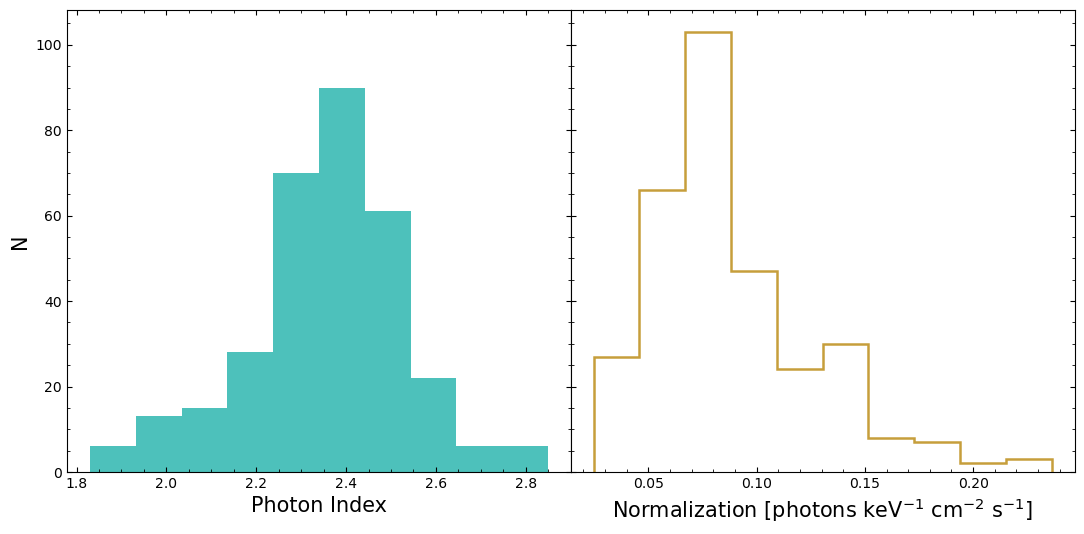

In [17]:
fig, ax_arr = plt.subplots(1, 2, sharey="row", figsize=(13, 6))
fig.subplots_adjust(wspace=0.0)

for ax_inds, ax in np.ndenumerate(ax_arr):
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True)

ax_arr[0].hist(pho_inds[:, 0], alpha=0.8, color="lightseagreen", histtype="stepfilled")
ax_arr[0].set_xlabel("Photon Index", fontsize=15)
ax_arr[0].set_ylabel("N", fontsize=15)

ax_arr[1].hist(norms[:, 0], alpha=0.8, color="darkgoldenrod", histtype="step", lw=1.8)
ax_arr[1].set_xlabel(
    r"Normalization [photons keV$^{-1}$ cm$^{-2}$ s$^{-1}$]", fontsize=15
)

plt.show()

### Do model parameters vary with time?

That might then make us wonder if the reason we're seeing these non-Gaussian distributions is due to Eta Car's
X-ray emission varying with time over the course of RXTE's campaign? Some kinds of X-ray sources are extremely
variable, and we know that Eta Car's X-ray emission is variable in other wavelengths.

As a quick check, we can retrieve the start time of each RXTE observation from the source spectra and then plot
the model parameter values against the time of their observation. In this case, we extract the modified Julian
date (MJD) reference time, the time system, and the start time (which is currently relative to the reference time).
Combining this information lets us convert the start time into a datetime object.

In [18]:
obs_start = []

for loc_sp in src_sp_files:
    with fits.open(os.path.join(spec_file_path, loc_sp)) as speco:
        cur_ref = Time(
            speco[0].header["MJDREFI"] + speco[0].header["MJDREFF"], format="mjd"
        )
        cur_tstart = Quantity(speco[0].header["TSTART"], "s")
        start_dt = (
            cur_ref
            + TimeDelta(
                cur_tstart, format="sec", scale=speco[0].header["TIMESYS"].lower()
            )
        ).to_datetime()
        obs_start.append(start_dt)

Now we actually plot the Photon Index and Normalization values against the start times, and we can see an extremely
strong indication of time varying X-ray emission from Eta Car:

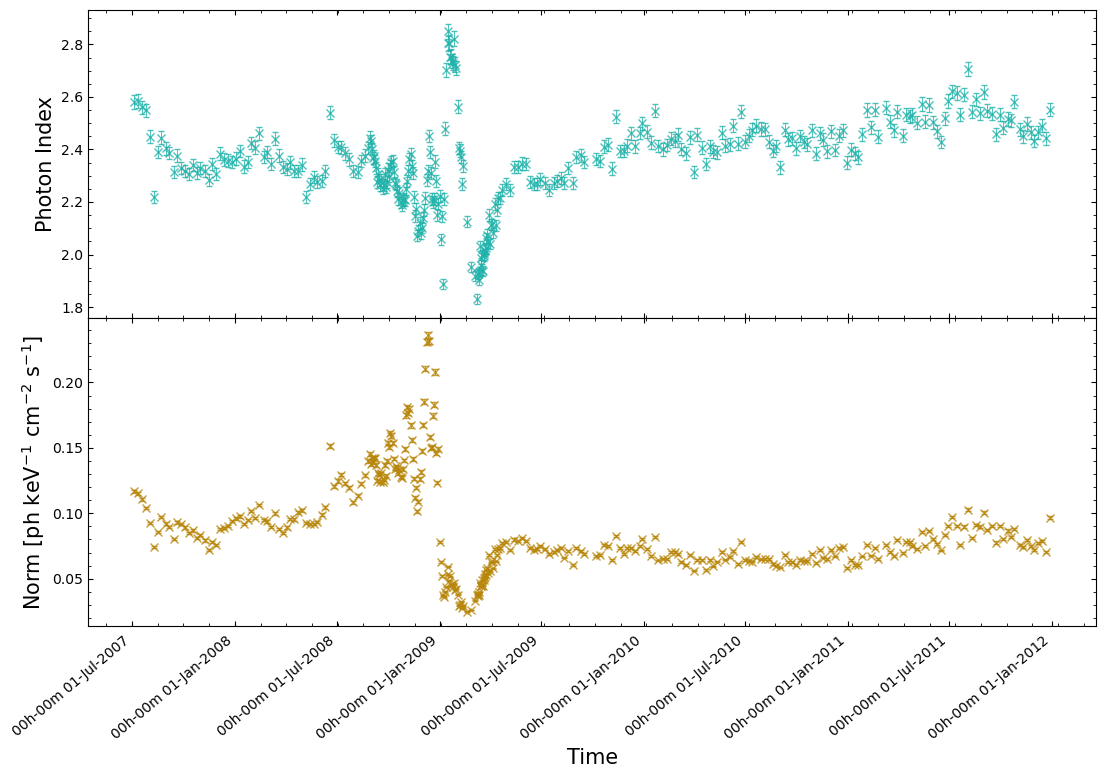

In [19]:
fig, ax_arr = plt.subplots(2, 1, sharex="col", figsize=(13, 8))
fig.subplots_adjust(hspace=0.0)

for ax_inds, ax in np.ndenumerate(ax_arr):
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True)

ax_arr[0].errorbar(
    obs_start,
    pho_inds[:, 0],
    yerr=pho_inds[:, 1],
    fmt="x",
    capsize=2,
    lw=0.7,
    alpha=0.8,
    color="lightseagreen",
)

ax_arr[0].set_ylabel("Photon Index", fontsize=15)
ax_arr[0].xaxis.set_major_formatter(mdates.DateFormatter("%Hh-%Mm %d-%b-%Y"))

ax_arr[1].errorbar(
    obs_start,
    norms[:, 0],
    yerr=norms[:, 1],
    fmt="x",
    capsize=2,
    lw=0.7,
    alpha=0.8,
    color="darkgoldenrod",
)

ax_arr[1].set_ylabel(r"Norm [ph keV$^{-1}$ cm$^{-2}$ s$^{-1}$]", fontsize=15)
ax_arr[1].xaxis.set_major_formatter(mdates.DateFormatter("%Hh-%Mm %d-%b-%Y"))
ax_arr[1].set_xlabel("Time", fontsize=15)

for label in ax_arr[1].get_xticklabels(which="major"):
    label.set(
        y=label.get_position()[1] - 0.01, rotation=40, horizontalalignment="right"
    )

plt.show()

## 5. Applying simple unsupervised machine learning to the spectra

From our previous analysis, fitting a simple power-law model to the spectra and plotting the parameters against
the time of their observation, we can see that some quite interesting spectral changes occur over the course of
RXTE's survey visits to Eta Car.

We might now want to know whether we can identify those same behaviors in a model independent way, to ensure that
it isn't just a strange emergent property of spectral model choice.

Additionally, if the spectral changes we observed through the fitted model parameters **are** representative of real
behavior, then are we seeing a single transient event where the emission returns to 'normal' after the most
significant changes, or is it entering a new 'phase' of its emission life cycle?

We are going to use some very simple machine learning techniques to explore these questions by:
- Reducing the spectra (with around one hundred energy bins and corresponding spectral values) to two dimensions.
- Using a clustering technique to group similar spectra together.
- Examining which spectra have been found to be the most similar.

### Preparing

Simply shoving the RXTE spectra that we already loaded in through some machine learning techniques is not likely to
produce useful results.

Machine learning techniques that reduce dataset dimensionality often benefit from re-scaling the datasets so that all
features (the spectral value for a particular energy bin, in this case) exist within the same general
range (-1 to 1, for example). This is because the distance between points is often used as some form of metric in
these techniques, and we wish to give every feature the same weight in those calculations.

It will hopefully mean that, for instance, the overall normalization isn't the one dominant factor
in grouping the spectra together, and instead other features (particularly the shape of a spectrum) will be
given weight as well.

#### Interpolating the spectra onto a common energy grid

Our first step is to place all the spectra onto a common energy grid. Due to changing calibration and instrument
response, we cannot guarantee that the energy bins of all our spectra are identical.

Looking at the first few energy bins of two different spectra, as an example:

In [20]:
print(spec_plot_data[0][0][:5])
print(spec_plot_data[40][0][:5])

[1.0708092413842678, 2.2686474323272705, 2.669748067855835, 3.0714478492736816, 3.473743438720703]
[1.0690011642873287, 2.2649662494659424, 2.6654340028762817, 3.0664981603622437, 3.4681555032730103]


The quickest and easiest way to deal with this is to define a common energy grid and then interpolate all of our
spectra onto it.

We choose to begin the grid at 2 keV to avoid low-resolution noise at lower energies, a limitation of RXTE-PCA data, and
to stop it at 12 keV due to a noticeable lack of emission from Eta Car above that energy. The grid will have a
resolution of 0.1 keV.

In [21]:
# Defining the specified energy grid
interp_en_vals = np.arange(2.0, 12.0, 0.1)

# Iterate through all loaded RXTE-PCA spectra
interp_spec_vals = []
for spec_info in spec_plot_data:
    # This runs the interpolation, using the values we extracted from PyXspec earlier.
    #  spec_info[0] are the energy values, and spec_info[2] the spectral values
    interp_spec_vals.append(np.interp(interp_en_vals, spec_info[0], spec_info[2]))

# Make the interpolated spectra into a numpy array
interp_spec_vals = np.array(interp_spec_vals)

#### Scaling and normalizing the spectra

As we've already mentioned, the machine learning techniques we're going to use will work best if the input data
are scaled. This `StandardScaler` class will move the mean of each feature (spectral value in an energy bin) to zero
and scale it unit variance.

In [22]:
scaled_interp_spec_vals = StandardScaler().fit_transform(interp_spec_vals)

#### Examining the scaled and normalized spectra

To demonstrate the changes we've made to our dataset, we'll visualize both the interpolated and the scaled-interpolated spectra:

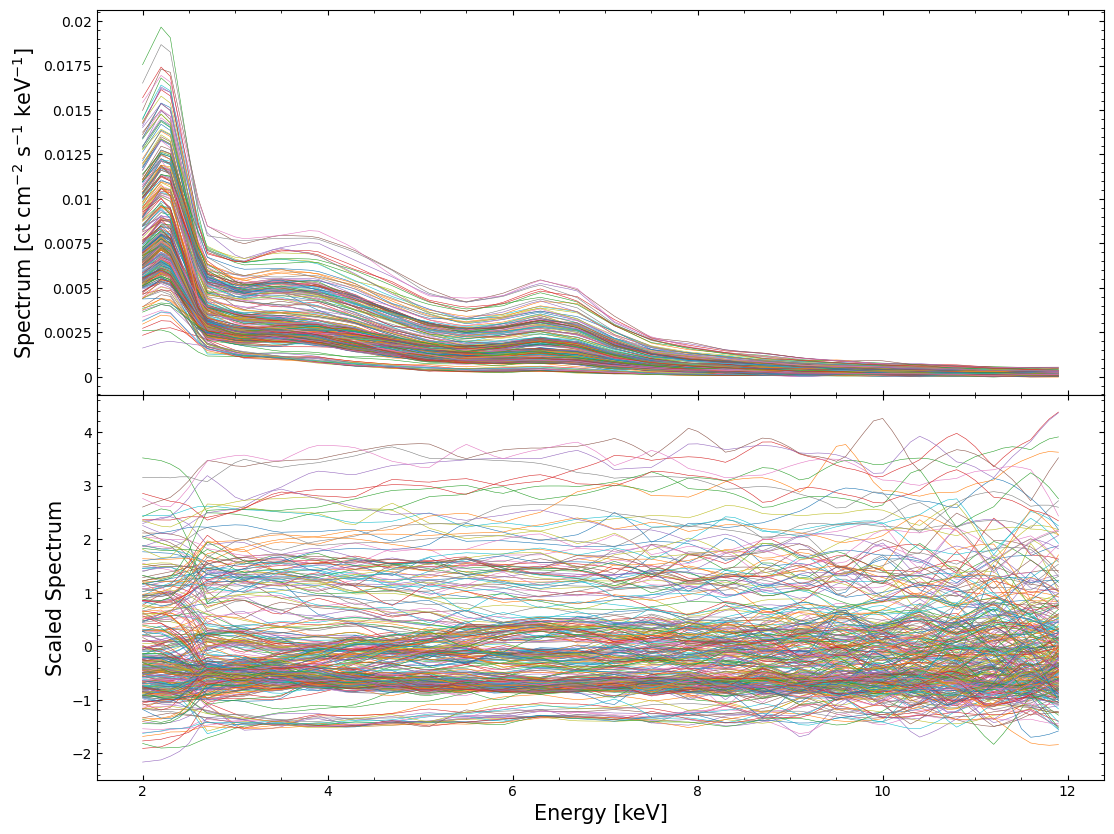

In [23]:
fig, ax_arr = plt.subplots(2, 1, sharex="col", figsize=(13, 10))
fig.subplots_adjust(hspace=0.0)

for ax_inds, ax in np.ndenumerate(ax_arr):
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True)

ax_arr[0].plot(interp_en_vals, interp_spec_vals.T, lw=0.4)

ax_arr[0].xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))
ax_arr[0].yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

ax_arr[0].set_ylabel(r"Spectrum [ct cm$^{-2}$ s$^{-1}$ keV$^{-1}$]", fontsize=15)

# Now for the scaled interpolated spectra
ax_arr[1].plot(interp_en_vals, scaled_interp_spec_vals.T, lw=0.4)

ax_arr[1].xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

ax_arr[1].set_ylabel(r"Scaled Spectrum", fontsize=15)
ax_arr[1].set_xlabel("Energy [keV]", fontsize=15)

plt.show()

### Reducing the dimensionality of the scaled spectral dataset

At this point, we _could_ try to find similar spectra by applying a clustering technique directly to the scaled
dataset we just created. However, it has been well demonstrated that finding similar data points (clustering them
together, in other words) is very difficult in high-dimensional data.

This is a result of something called "the curse of dimensionality"
([see, Karanam, Shashmi; 2021, for an overview](https://towardsdatascience.com/curse-of-dimensionality-a-curse-to-machine-learning-c122ee33bfeb/)), a common problem in machine learning and data science.


One of the ways to combat this issue is to try and reduce the dimensionality of the dataset. The hope is that the
data point that represents a spectrum (in N dimensions, where N is the number of energy bins in our interpolated
spectrum) can be projected/reduced to a much smaller number of dimensions without losing the information that will
help us group the different spectra.

We're going to try three common dimensionality reduction techniques:
- Principal Component Analysis (PCA)
- T-distributed Stochastic Neighbor Embedding (t-SNE)
- Uniform Manifold Approximation and Projection (UMAP)

An article by [Varma, Aastha (2024)](https://medium.com/@aastha.code/dimensionality-reduction-pca-t-sne-and-umap-41d499da2df2) provides
simple summaries of these three techniques and when they can be used. We encourage you to identify resources that
explain whatever dimensionality reduction technique you may end up using, as it is all too easy to treat these
techniques as black boxes.

#### Principal Component Analysis (PCA)

PCA is arguably the simplest of the dimensionality reduction techniques that we're trying out in this
demonstration. The technique works by projecting the high-dimensionality data into a lower-dimension parameter
space (two dimensions, in this case) whilst maximizing the variance of the projected data.

PCA is best suited to linearly separable data, but isn't particularly suitable for non-linear relationships.

In [24]:
pca = PCA(n_components=2)

scaled_specs_pca = pca.fit_transform(scaled_interp_spec_vals)

#### T-distributed Stochastic Neighbor Embedding (t-SNE)

Unlike PCA, t-SNE **is** suited to non-linearly separable data, though it is also much more computationally
expensive. This technique works by comparing two distributions:
- Pairwise similarities (defined by some distance metric) of the data points in the original high-dimensional data.
- The equivalent similarities but in the projected two-dimensional space.

The goal is to minimize the divergence between the two distributions and effectively try to represent the
same spacings between data points in N-dimensions in a two-dimensional space.

In [25]:
tsne = TSNE(n_components=2)
scaled_specs_tsne = tsne.fit_transform(scaled_interp_spec_vals)

#### Uniform Manifold Approximation and Projection (UMAP)

Finally, the UMAP technique is also well suited to non-linearly separable data. It also does well at preserving
and representing local and global structures from the original N-dimensional data in the output
two-dimensional (in our case) space.

UMAP in particular is mathematically complex (compared to the other two techniques
we're using) - a full explanation [by the UMAP Contributors](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html) is included in the documentation.

The original paper describing UMAP ([McInnes et al. 2018](https://ui.adsabs.harvard.edu/link_gateway/2018arXiv180203426M/doi:10.48550/arXiv.1802.03426)) may also be useful.

In [26]:
um = UMAP(random_state=1, n_jobs=1)
scaled_specs_umap = um.fit_transform(scaled_interp_spec_vals)

#### Comparing the results of the different dimensionality reduction methods

In each case, we reduced the scaled spectral dataset to two dimensions, so it is easy to visualize how each
technique has behaved. We're going to visually assess the separability of data point groups (we are starting with the
assumption that there _will_ be some distinct groupings of spectra).

Just from a quick look, it is fairly obvious that UMAP has done the best job of forming distinct, separable, groupings
of spectra. **That doesn't necessarily mean that those spectra are somehow physically linked**, but it does seem like
it will be the best dataset to run our clustering algorithm on.

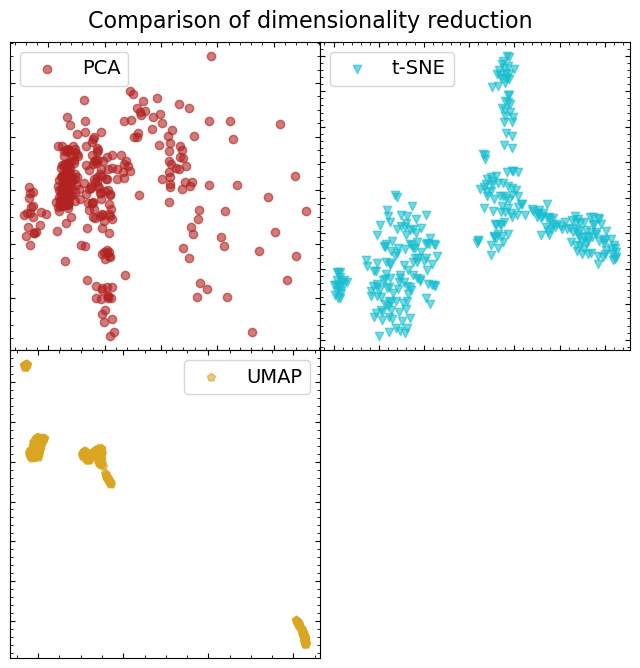

In [27]:
fig, ax_arr = plt.subplots(2, 2, figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for ax_inds, ax in np.ndenumerate(ax_arr):
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True)

# PCA plot
ax_arr[0, 0].scatter(
    scaled_specs_pca[:, 0],
    scaled_specs_pca[:, 1],
    alpha=0.6,
    color="firebrick",
    label="PCA",
)
ax_arr[0, 0].set_xticklabels([])
ax_arr[0, 0].set_yticklabels([])
ax_arr[0, 0].legend(fontsize=14)

# t-SNE plot
ax_arr[0, 1].scatter(
    scaled_specs_tsne[:, 0],
    scaled_specs_tsne[:, 1],
    alpha=0.6,
    color="tab:cyan",
    marker="v",
    label="t-SNE",
)
ax_arr[0, 1].set_xticklabels([])
ax_arr[0, 1].set_yticklabels([])
ax_arr[0, 1].legend(fontsize=14)

# UMAP plot
ax_arr[1, 0].scatter(
    scaled_specs_umap[:, 0],
    scaled_specs_umap[:, 1],
    alpha=0.6,
    color="goldenrod",
    marker="p",
    label="UMAP",
)
ax_arr[1, 0].set_xticklabels([])
ax_arr[1, 0].set_yticklabels([])
ax_arr[1, 0].legend(fontsize=14)

# Make the fourth subplot invisible
ax_arr[1, 1].set_visible(False)

plt.suptitle("Comparison of dimensionality reduction", fontsize=16, y=0.92)

plt.show()

### Automated clustering of like spectra with Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

There are a litany of clustering algorithms implemented in scikit-learn, all with different characteristics,
strengths, and weaknesses. The scikit-learn website provides an interesting comparison
([Scikit-learn Contributors](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)) of
their performance on different toy datasets, which gives an idea of what sorts of features can be separated
with each approach.

Some algorithms require that you specify the number of clusters you want to find, which is not particularly easy to do
while doing this sort of exploratory data analysis. As such, we're going to use 'DBSCAN', which identifies dense
cores of data points and expands clusters from them. You should read about a variety of clustering techniques and
how they work before deciding on one to use for your own scientific work.

In [28]:
dbs = DBSCAN(eps=0.6, min_samples=2)
clusters = dbs.fit(scaled_specs_umap)

# The labels of the point clusters
clust_labels = np.unique(clusters.labels_)
clust_labels

array([0, 1, 2, 3, 4, 5, 6])

We will once again visualize the UMAP-reduced spectral dataset, but this time we'll color each data point by the
cluster that DBSCAN says it belongs to. That will give us a good idea of how well the algorithm has performed:

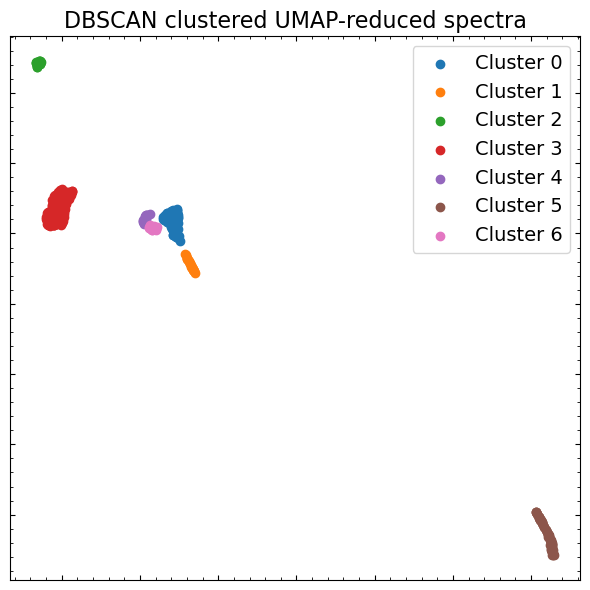

In [29]:
plt.figure(figsize=(6, 6))

plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

for clust_id in clust_labels:
    plt.scatter(
        scaled_specs_umap[clusters.labels_ == clust_id, 0],
        scaled_specs_umap[clusters.labels_ == clust_id, 1],
        label=f"Cluster {clust_id}",
    )

plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

plt.title("DBSCAN clustered UMAP-reduced spectra", fontsize=16)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

### Exploring the results of spectral clustering

Now that we think we've identified distinct groupings of spectra that are similar (in the two-dimensional space
produced by UMAP at least), we can look to see whether they look distinctly different in their original
high-dimensional parameter space!

Here we examine both unscaled and scaled versions of the interpolated spectra, but rather than coloring every
individual spectrum by the cluster that it belongs to, we instead plot the mean spectrum of each cluster.

This approach makes it much easier to interpret the figures, and we can see straight away that most of the
mean spectra of the clusters are quite distinct from one another:

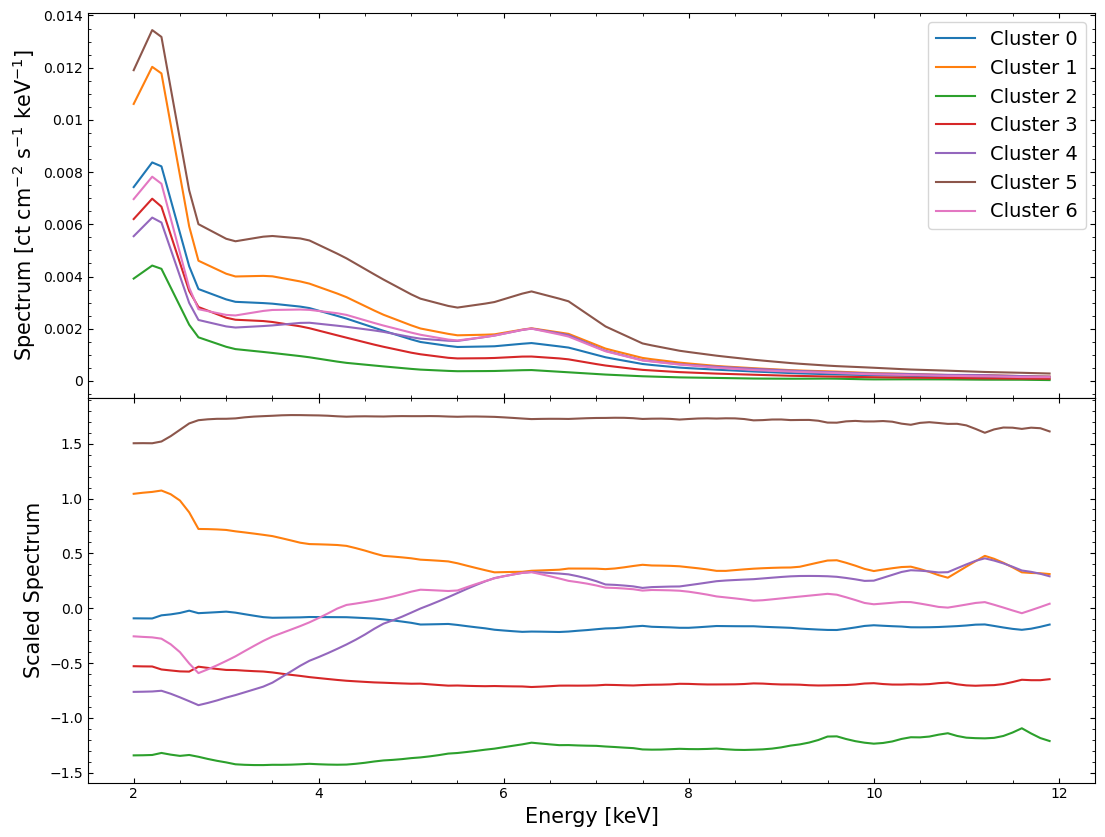

In [30]:
fig, ax_arr = plt.subplots(2, 1, sharex="col", figsize=(13, 10))
fig.subplots_adjust(hspace=0.0)

for ax_inds, ax in np.ndenumerate(ax_arr):
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True)

for clust_id in np.unique(clusters.labels_):
    mean_spec = interp_spec_vals[clusters.labels_ == clust_id].mean(axis=0)
    ax_arr[0].plot(interp_en_vals, mean_spec.T, label=f"Cluster {clust_id}")

ax_arr[0].xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))
ax_arr[0].yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

ax_arr[0].set_ylabel(r"Spectrum [ct cm$^{-2}$ s$^{-1}$ keV$^{-1}$]", fontsize=15)
ax_arr[0].legend(fontsize=14)

for clust_id in np.unique(clusters.labels_):
    mean_scaled_spec = scaled_interp_spec_vals[clusters.labels_ == clust_id].mean(
        axis=0
    )
    ax_arr[1].plot(interp_en_vals, mean_scaled_spec.T, label=f"Cluster {clust_id}")

ax_arr[1].xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

ax_arr[1].set_ylabel(r"Scaled Spectrum", fontsize=15)
ax_arr[1].set_xlabel("Energy [keV]", fontsize=15)

plt.show()

Having done all of this, we can return to the original goal of this section and look to see whether the significant
time-dependent behaviors of our fitted model parameters are also identified through this model-independent
approach. Additionally, if they are identified this way, are the spectra before and after the most significant changes
different, or did the emission return to 'normal' after the disruption?

We plot the same figure of power-law photon index versus time that we did earlier, but now we can color the data
points by which point cluster their spectrum is associated with.

From this plot it seems like the significant fluctuations of photon index with time **are not an emergent property
of our model choice**, and instead represent real differences in the RXTE-PCA spectra of Eta Car at different
observation times!

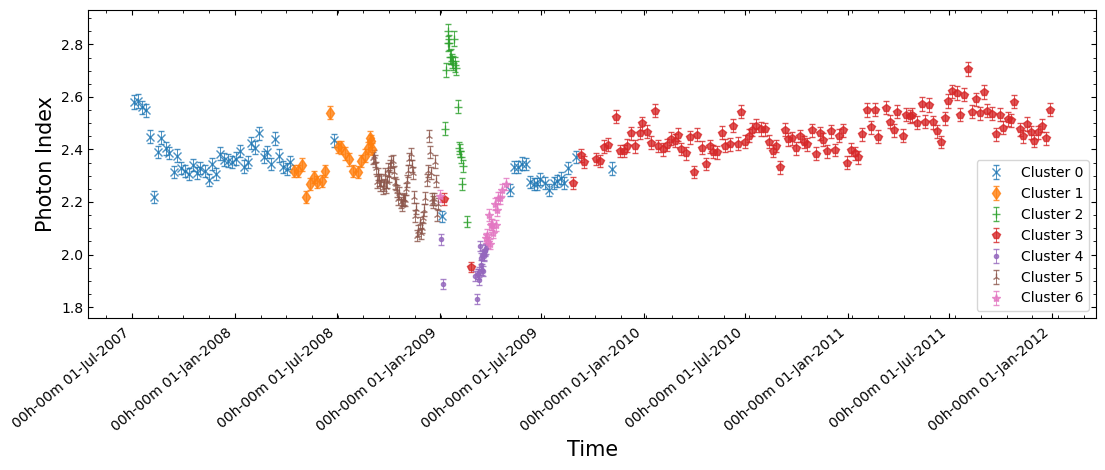

In [31]:
marker_cycler = cycler(marker=["x", "d", "+", "p", ".", "2", "*", "H", "X", "v"])
default_color_cycler = plt.rcParams["axes.prop_cycle"]
new_cycler = marker_cycler + default_color_cycler

fig = plt.figure(figsize=(13, 4))

plt.gca().set_prop_cycle(new_cycler)

plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

for clust_id in np.unique(clusters.labels_):
    cur_mask = clusters.labels_ == clust_id

    plt.errorbar(
        np.array(obs_start)[cur_mask],
        pho_inds[cur_mask, 0],
        yerr=pho_inds[cur_mask, 1],
        capsize=2,
        lw=0.7,
        alpha=0.8,
        label=f"Cluster {clust_id}",
        linestyle="None",
    )

plt.ylabel("Photon Index", fontsize=15)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Hh-%Mm %d-%b-%Y"))
plt.xlabel("Time", fontsize=15)

for label in plt.gca().get_xticklabels(which="major"):
    label.set(
        y=label.get_position()[1] - 0.01, rotation=40, horizontalalignment="right"
    )

plt.legend()
plt.show()

***



## About this notebook

Author: Tess Jaffe, HEASARC Chief Archive Scientist.

Author: David J Turner, HEASARC Staff Scientist.

Updated On: 2026-01-19

### Additional Resources

Support: [HEASARC RXTE Helpdesk](https://heasarc.gsfc.nasa.gov/cgi-bin/Feedback?selected=xte)

Documents:
- [RXTE ABC Guide](https://heasarc.gsfc.nasa.gov/docs/xte/abc/front_page.html)
- [Description of standard RXTE data products](https://heasarc.gsfc.nasa.gov/docs/xte/recipes/stdprod_guide.html)


### Acknowledgements

### References

[Karanam, Shashmi (2021) - 'Curse of Dimensionality; A "Curse" to Machine Learning' [ACCESSED 19-JAN-2026]](https://towardsdatascience.com/curse-of-dimensionality-a-curse-to-machine-learning-c122ee33bfeb/)

[Varma, Aastha (2024) - 'Dimensionality Reduction: PCA, t-SNE, and UMAP' [ACCESSED 19-JAN-2026]](https://medium.com/@aastha.code/dimensionality-reduction-pca-t-sne-and-umap-41d499da2df2)

[UMAP Contributors - 'How UMAP Works' [ACCESSED 19-JAN-2026]](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)

[McInnes et al. (2018) - 'UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction'](https://ui.adsabs.harvard.edu/link_gateway/2018arXiv180203426M/doi:10.48550/arXiv.1802.03426)

[Scikit-learn Contributors - Comparing different clustering algorithms on toy datasets [ACCESSED 19-JAN-2026]](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)